# Face Mask Detection

Simple face mask detection program for univeristy project using Transfer Learning from DenseNet


Datasets used are from Kaggle:
* https://www.kaggle.com/andrewmvd/face-mask-detection - 852 Photos
* https://www.kaggle.com/ashishjangra27/face-mask-12k-images-dataset - ~12k Photos

In [63]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import cv2 # Computer Vision
# Net libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img ,img_to_array
from tensorflow.keras import Model
from tensorflow.keras.layers import  Flatten, Dense, Dropout
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras import optimizers
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [64]:
# Setup some gloabal variables

# Make by default all fig sized 10 ,6
plt.rcParams["figure.figsize"] = (10,6)

# Setup Global Batch size
BATCH_SIZE = 64

# Set up image Target size
TARGET_SIZE = (224,224)


In [65]:
# Get path from google drive
path = "/content/drive/MyDrive/Face_Mask_Detection/large_face_mask_dataset"
example_with_mask = path + "/Train/WithMask/1209.png"
example_without_mask = path + "/Train/WithoutMask/17.png"

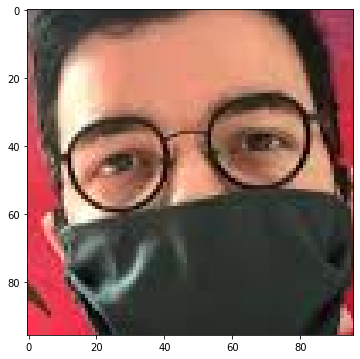

In [66]:
# Print example photo with mask
plt.imshow(load_img(example_with_mask));

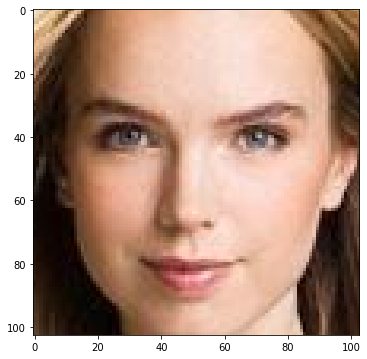

In [67]:
# Print example photo without mask
plt.imshow(load_img(example_without_mask));

# Lets make an image generator to better our data

In [68]:
# Training Image Generator
train_datagen = ImageDataGenerator(rescale= 1./255, # Normalizing our data,
                                   rotation_range = 10, # Rotates image
                                   width_shift_range = 0.2, # Slightly shifts image
                                   height_shift_range=0.2, 
                                   zoom_range=0.25,         # Slight zoom to image
                                   horizontal_flip=True, 
                                   samplewise_center=True, 
                                   samplewise_std_normalization=True,
                                   fill_mode = "nearest")

# Test image generator
test_datagen = ImageDataGenerator(rescale= 1./255 ) # Simply normalize data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

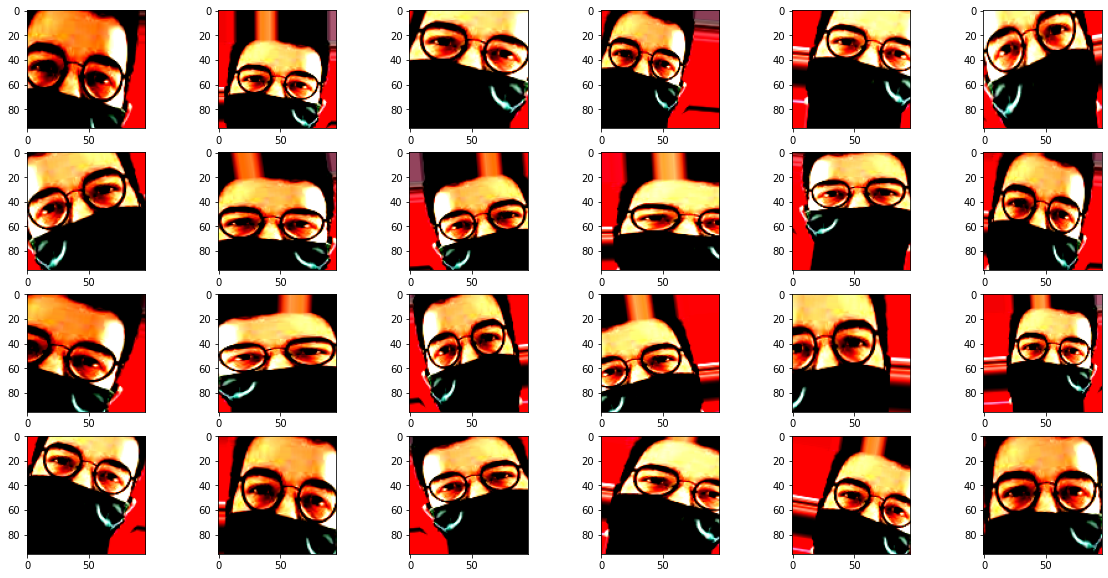

In [69]:
# Lets plot the mask example with Image Generator

img = load_img(example_with_mask)
example_aug = img_to_array(img)/255.

# Inputs have 4 axis so we need to add extra empty axis
example_aug = example_aug[np.newaxis]

# Increase figsize
plt.figure(figsize=(20,10))
# Time to view example images with the image generator
for i , img in enumerate(train_datagen.flow(example_aug,batch_size=1)):
  plt.subplot(4,6,i+1) # Subplot for each different change
  # SHow the images
  plt.imshow(np.squeeze(img)) # Squeezing removes the extra axis
  if i >= 23:
    break
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

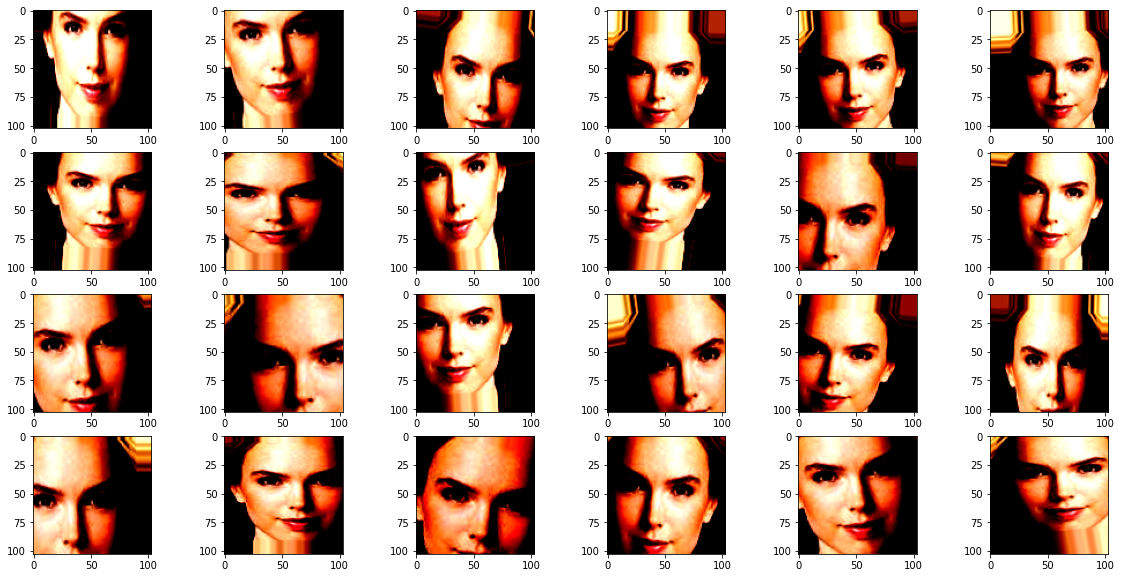

In [70]:
# Lets plot without the mask image with Image Generator

img = load_img(example_without_mask)
example_aug = img_to_array(img)/255.

# Inputs have 4 axis so we need to add extra empty axis
example_aug = example_aug[np.newaxis]

# Increase figsize
plt.figure(figsize=(20,10))
# Time to view example images with the image generator
for i , img in enumerate(train_datagen.flow(example_aug,batch_size=1)):
  plt.subplot(4,6,i+1) # Subplot for each different change
  # SHow the images
  plt.imshow(np.squeeze(img)) # Squeezing removes the extra axis
  if i >= 23:
    break
plt.show()

# Time to ready our training and validation data

In [71]:
train_set = train_datagen.flow_from_directory(directory= path + "/Train",
                                              batch_size = BATCH_SIZE,
                                              class_mode = "categorical",
                                              target_size = TARGET_SIZE)

validation_set = test_datagen.flow_from_directory(path + "/Validation",
                                                  target_size=TARGET_SIZE)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


# Now we have our data ready,time to build the model

In [78]:
# Function to build the model
def create_model():
  transfer_densenet_model = DenseNet201(input_shape= TARGET_SIZE + (3,), # Rgh
                                        weights = 'imagenet',
                                        include_top = "False")
  
  transfer_densenet_model.trainable = False # We only need to train our parameters
  flatten = Flatten()(transfer_densenet_model.layers[-1].output)
  fc = Dense(units=512 ,activation="relu")(flatten)
  dropout = Dropout(0.35)(fc)
  output = Dense(2,activation="softmax")(dropout)

  model = Model(inputs = transfer_densenet_model.input, 
                outputs= output)

  return model

### Create first model

In [79]:
model_1 = create_model()

## Set up Learning rate which will range between 0.01 and 0.00001

In [81]:
starting_learning_rate = 1e-2
end_learning_rate = 1e-6
decay_steps = 1000
learning_rate = optimizers.schedules.PolynomialDecay(starting_learning_rate,
                                                     decay_steps,
                                                     end_learning_rate,
                                                     power=0.4)
# Compile the model
model_1.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate),
                metrics = ["accuracy"])

## Set up callback optimizers

In [89]:
callback = [
  tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy",
                                  min_delta = 1e-5,
                                  patience = 5,
                                  mode = "auto",
                                  restore_best_weights = False,
                                  verbose = 0),
            
  tf.keras.callbacks.ModelCheckpoint(filepath = "face_mask_model.h5",
                                     monitor ="accuracy",
                                     save_best_only = True,
                                     save_weights_only = True,
                                     save_freq = "epoch",
                                     mode = "auto",
                                     verbose=0)
]

# Time to fit our model to the data>

In [90]:
history_1 = model_1.fit(train_set,
                        epochs = 2 ,
                        steps_per_epoch = len(train_set),
                        validation_data = validation_set,
                        callbacks = [callback],
                        verbose = 1)

Epoch 1/8
157/157 [==============================] - 3064s 19s/step - loss: 0.1043 - accuracy: 0.9714 - val_loss: 0.0723 - val_accuracy: 0.9850
Epoch 2/8
157/157 [==============================] - 125s 793ms/step - loss: 0.0555 - accuracy: 0.9828 - val_loss: 0.0612 - val_accuracy: 0.9850
Epoch 3/8
157/157 [==============================] - 126s 802ms/step - loss: 0.0482 - accuracy: 0.9859 - val_loss: 0.0578 - val_accuracy: 0.9862
Epoch 4/8
157/157 [==============================] - 124s 791ms/step - loss: 0.0426 - accuracy: 0.9865 - val_loss: 0.0475 - val_accuracy: 0.9850
Epoch 5/8
157/157 [==============================] - 124s 791ms/step - loss: 0.0419 - accuracy: 0.9879 - val_loss: 0.0448 - val_accuracy: 0.9875
Epoch 6/8
157/157 [==============================] - 124s 790ms/step - loss: 0.0353 - accuracy: 0.9893 - val_loss: 0.0450 - val_accuracy: 0.9862
Epoch 7/8
157/157 [==============================] - 124s 790ms/step - loss: 0.0349 - accuracy: 0.9881 - val_loss: 0.0433 - val_acc

In [91]:
def plot_history(history):
  pd.DataFrame(history.history).plot()
  plt.ylabel("loss")
  plt.xlabel("epochs")

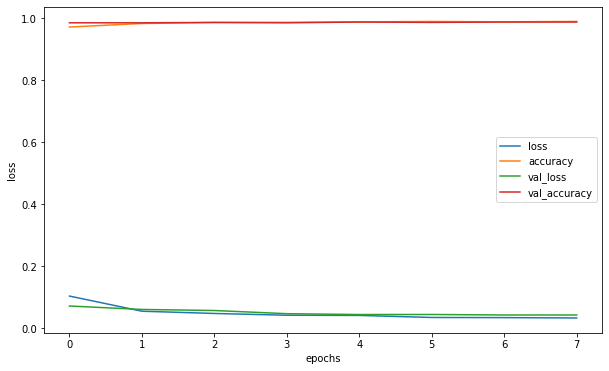

In [92]:
plot_history(history_1)

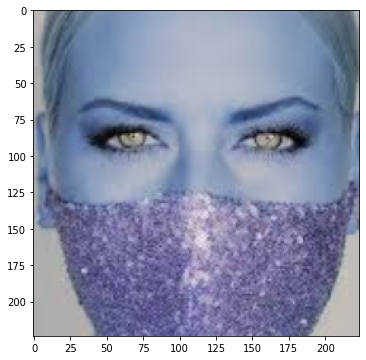

In [104]:
# Lets try on on a sample image
sample_mask_image = cv2.imread("/content/drive/MyDrive/Face_Mask_Detection/large_face_mask_dataset/Test/WithMask/45.png")
samle_nomask_image = cv2.imread("/content/drive/MyDrive/Face_Mask_Detection/large_face_mask_dataset/Test/WithoutMask/45.png")

sample_mask_image = cv2.resize(sample_mask_image,(224,224))
plt.imshow(sample_mask_image);

In [171]:
test_set = test_datagen.flow_from_directory(path + '/Test',target_size=TARGET_SIZE,shuffle=False)

Found 992 images belonging to 2 classes.


In [178]:
test_set.batch_size

32

In [229]:
def plot_images(model,test_set,test=False):
  image, label = test_set.next()
  num_imgs = 20
  lab_names = ['Has Mask','Without Mask ']
  images = image[0:num_imgs,:,:,:]
  labels = label[0:num_imgs,:]
  predict = np.round(model.predict(images))

  image_rows = 4
  image_col = int(num_imgs/image_rows)

  _, axs = plt.subplots(image_rows, image_col, figsize=(32,8))
  axs = axs.flatten()

  for i in range(num_imgs):
      img = images[i,:,:,:]
      lab = labels[i,:]
      axs[i].imshow(img)
      pred = predict[i]
      axs[i].axis('off')

      lab, pred = np.argmax(lab), np.argmax(pred)
      if lab_names[lab] == lab_names[pred]:
        color = "green"
      else:
          color = "red"
      if test == False:
        axs[i].set_title(label = f'predicted: {lab_names[pred]}  |  actual: {lab_names[lab]}',color=color, fontsize=14)
      else:
        axs[i].set_title(label = f"Predicted {lab_names[pred]}")

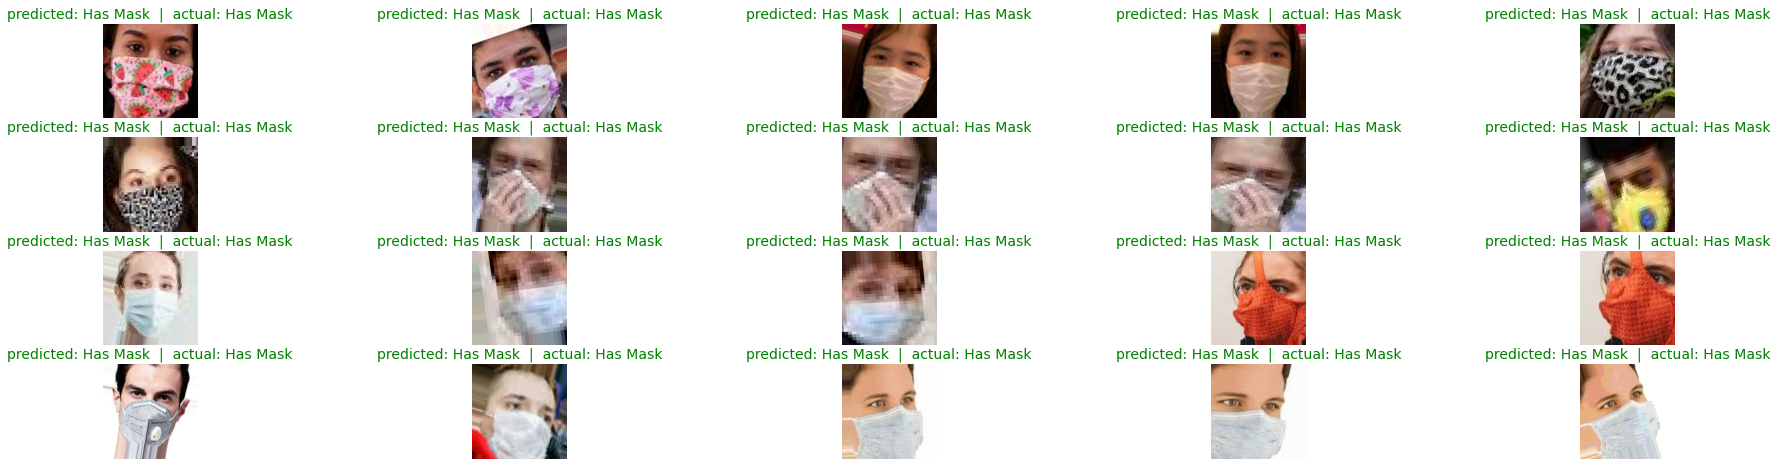

In [230]:
plot_images(model_1,test_set)

In [224]:
extra_image_path = "/content/drive/MyDrive/Face_Mask_Detection/images"
extra_images = test_datagen.flow_from_directory(extra_image_path,target_size=TARGET_SIZE,
                                                shuffle=True)

another_test_set.filepaths

Found 853 images belonging to 1 classes.


[]

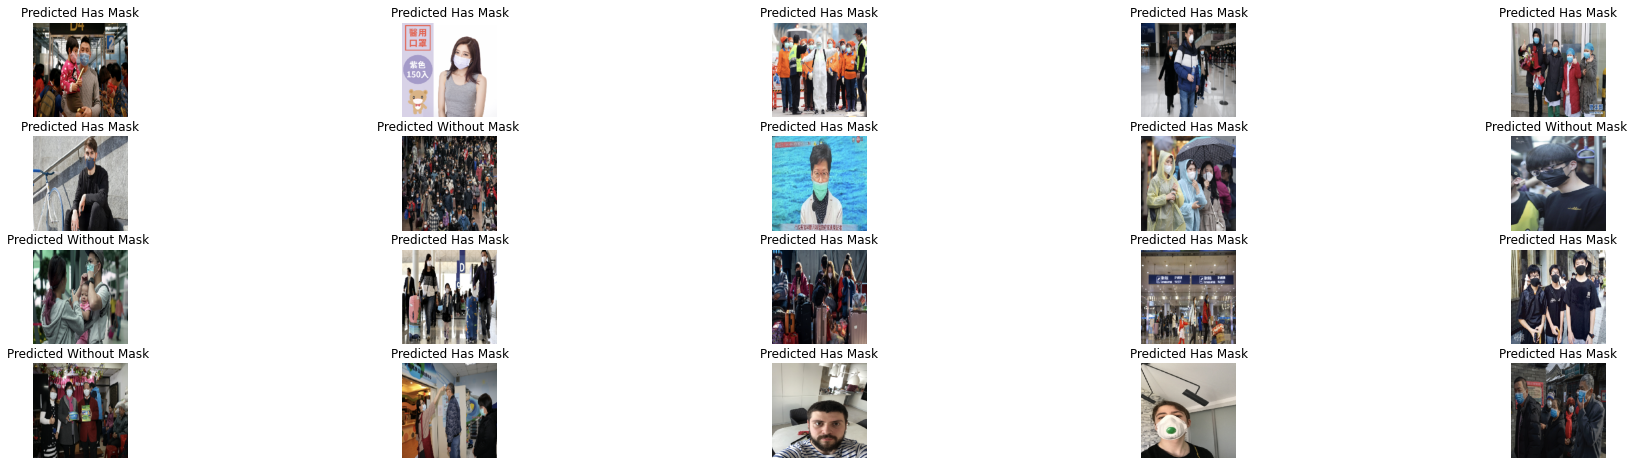

In [231]:
plot_images(model_1,extra_images,test=True)

# Since the model is complete its time to add  face detection using haar cascade

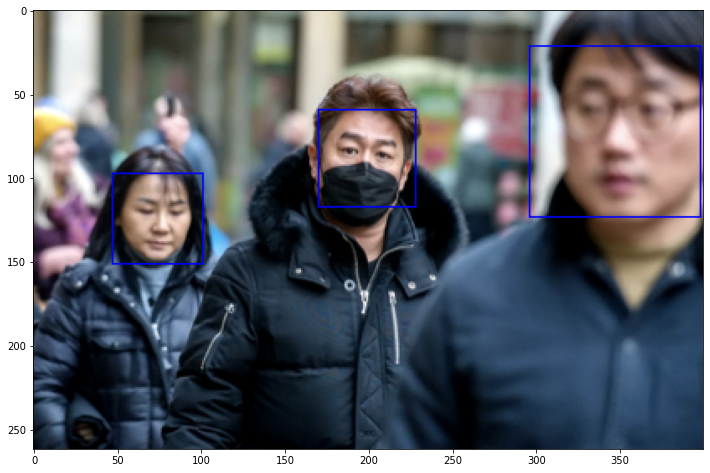

In [218]:
face_model = cv2.CascadeClassifier("/content/drive/MyDrive/Face_Mask_Detection/haarcascades/haarcascade_frontalface_default.xml")
img = cv2.imread('/content/drive/MyDrive/Face_Mask_Detection/images/Actual_Images/maksssksksss244.png')


img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

faces = face_model.detectMultiScale(img,scaleFactor=1.1, minNeighbors=4) #returns a list of (x,y,w,h) tuples

out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image

#plotting
for (x,y,w,h) in faces:
    cv2.rectangle(out_img,(x,y),(x+w,y+h),(0,0,255),1)
plt.figure(figsize=(12,12))
plt.imshow(out_img);

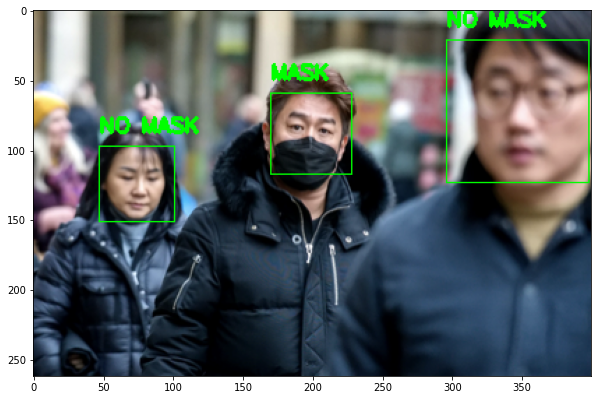

In [221]:
mask_label = {0:'MASK',1:'NO MASK'}
dist_label = {0:(0,255,0),1:(255,0,0)}

if len(faces)>=0:
    label = [0 for i in range(len(faces))]
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
    
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        crop = new_img[y:y+h,x:x+w]
        crop = cv2.resize(crop,(128,128))
        crop = np.reshape(crop,[1,128,128,3])/255.0
        mask_result = model_1.predict(crop)
        cv2.putText(new_img,mask_label[mask_result.argmax()],(x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,dist_label[label[i]],2)
        cv2.rectangle(new_img,(x,y),(x+w,y+h),dist_label[label[i]],1)
    plt.figure(figsize=(10,10))
    plt.imshow(new_img)
            